In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
import sys
import rich
import pickle


import xobjects as xo
import xtrack as xt
import xpart as xp

sys.path.append('../')
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.InteractionPoint as inp
import BBStudies.Physics.Detuning as dtune
import BBStudies.Physics.Base as phys
import BBStudies.Plotting.BBPlots as bbplt
import BBStudies.Physics.Constants as cst


LINEFOLDER   = '../Data/Lines/'
SURVEYFOLDER = '../Data/Surveys/'
df_columns = ['name', 's', 'x', 'px', 'y', 'py', 'zeta', 'delta', 'ptau', 'betx', 'bety', 'alfx', 'alfy', 'gamx', 'gamy', 'dx', 'dpx', 'dy', 'dpy', 'mux', 'muy', 'qx', 'qy', 'qs', 'dqx', 'dqy']


line   = {}
twiss  = {}
survey = {}

# Importing survey
for seq in ['lhcb1','lhcb2']:
    _beam = seq[-2:]
    survey[_beam] = pd.read_pickle(SURVEYFOLDER + f'survey_opticsfile32_{seq}.pkl')

# Importing twiss
for seq in ['lhcb1','lhcb4']:
    _beam = seq[-2:]
    
    # Importing Line
    line[_beam] = xPlus.importLine(LINEFOLDER + f'line_opticsfile32_{seq}.json')
    
    # Importing twiss and tracker
    if _beam == 'b1':
        tracker = xt.Tracker(line=line[_beam])
        xtwiss  = tracker.twiss()
    else:
        xtwiss  = xt.Tracker(line=line[_beam]).twiss()
    
    twiss[_beam]= pd.DataFrame(xtwiss,columns = df_columns)
    twiss[_beam].set_index('name',inplace=True)


# Creating twiss b2 from b4
#==========================================
twiss['b2'] = xPlus.twiss_b2_from_b4(twiss['b4'])



# Clearing xsuite ouput
clear_output(wait=False)






# Filtering twiss (Needed for IP objects)
#====================================
twiss['b1'] = xPlus.filter_twiss(twiss['b1'],entries=['drift','..'])
twiss['b2'] = xPlus.filter_twiss(twiss['b2'],entries=['drift','..','bbcw'])
#====================================
B1 = inp.Beam('b1',twiss['b1'],survey['b1'],
              Nb       = 1.15e11,
              E        = 6.8e12,
              emittx_n = 2.5e-6,
              emitty_n = 2.5e-6,
              dp_p0    = 0)
    
B2 = inp.Beam('b2',twiss['b2'],survey['b2'],
              Nb       = 1.15e11,
              E        = 6.8e12,
              emittx_n = 2.5e-6,
              emitty_n = 2.5e-6,
              dp_p0    = 0)

IP1 = inp.InteractionPoint('ip1',B1,B2)
IP5 = inp.InteractionPoint('ip5',B1,B2)


beam = 'b1'
# Deactivating all wires
#===================================================
tracker.vars['enable_qff'] = 0
for IP in ['ip1','ip5']:
    tracker.vars[f"bbcw_rw_{IP}.{beam}"] = 1
    tracker.vars[f"bbcw_i_{IP}.{beam}"]  = 0

    
# Creating BB knobs
#===================================================
allVars = list(tracker.vars._owner.keys())
allElements = list(tracker.element_refs._owner.keys())


for _ip in ['ip1','ip5','ip2','ip8']:
    bb_lr = [name for name in allElements if ('bb_lr' in name)&(f'{_ip[-1]}b1' in name)]
    bb_ho = [name for name in allElements if ('bb_ho' in name)&(f'{_ip[-1]}b1' in name)]

    # New knob:
    tracker.vars[f'{_ip}_bblr_ON'] = 1
    tracker.vars[f'{_ip}_bbho_ON'] = 1

    # Linking to new knob 
    for _lr in bb_lr:
        # Infividual knobs
        tracker.vars[f'{_lr}_ON'] = 1
        tracker.element_refs[_lr].other_beam_num_particles = tracker.vars[f'{_lr}_ON']*tracker.vars[f'{_ip}_bblr_ON']*tracker.element_refs[_lr].other_beam_num_particles._value
        


    for _ho in bb_ho:
        tracker.element_refs[_ho].slices_other_beam_num_particles = tracker.vars[f'{_ip}_bbho_ON']*tracker.element_refs[_ho].slices_other_beam_num_particles._value[0]

# Creating sext and oct knobs
#====================================================
ks = [name for name in allVars if ('ksf' in name)|('ksd' in name)]
ko = [name for name in allVars if ('kof.a' in name)|('kod.a' in name)]

tracker.vars['all_oct_ON']  = 1
tracker.vars['all_sext_ON'] = 1
for _ks in ks:
    if tracker.vars[_ks]._expr is None:
        tracker.vars[_ks] = tracker.vars['all_sext_ON']*tracker.vars[_ks]._value
    else:
        tracker.vars[_ks] = tracker.vars['all_sext_ON']*tracker.vars[_ks]._expr 
for _ko in ko:
    if tracker.vars[_ko]._expr is None:
        tracker.vars[_ko] = tracker.vars['all_oct_ON']*tracker.vars[_ko]._value
    else:
        tracker.vars[_ko] = tracker.vars['all_oct_ON']*tracker.vars[_ko]._expr 

In [10]:
line.beam

AttributeError: 'dict' object has no attribute 'beam'

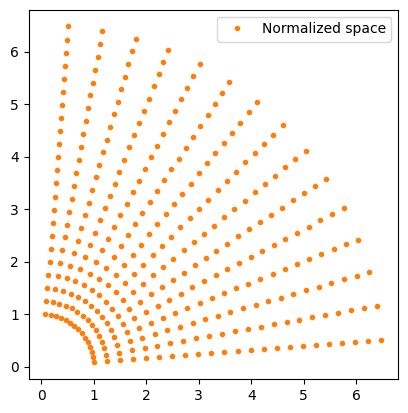

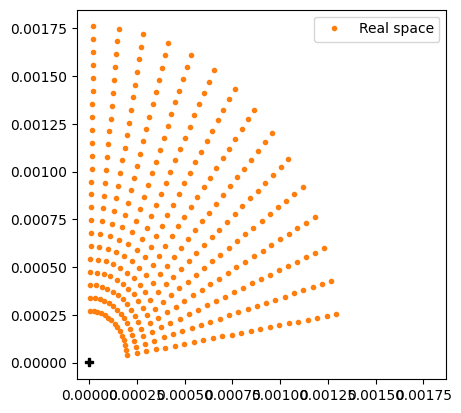

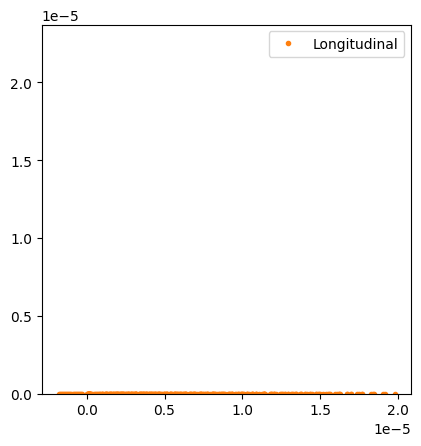

In [2]:


def generate_particles():
    # Generating Coord grid
    #=========================================================
    coordinates = phys.polar_grid(  r_sig     = np.linspace(1,6.5,23),
                                    theta_sig = np.linspace(0.05*np.pi/2,0.95*np.pi/2,15),
                                    emitt     = [B1.emittx,B1.emitty])
    coordinates.insert(0,'delta',0)
    group_length = len(coordinates)

    #coordinates = pd.concat([coordinates,coordinates,coordinates],ignore_index=True)
    #coordinates.loc[group_length:2*group_length,'delta'] = 0.55e-4#2.5e-9*tracker.line.particle_ref.beta0[0]*cst.c
    #coordinates.loc[2*group_length:,'delta']             = 1.10e-4#2.5e-9*tracker.line.particle_ref.beta0[0]*cst.c



    # Generation
    p0        = xp.Particles(mass0=tracker.line.particle_ref.mass0, q0 = tracker.line.particle_ref.q0 , p0c=tracker.line.particle_ref.p0c)
    particles = xp.build_particles( particle_ref = p0,
                                    tracker      = tracker,
                                    x_norm       = coordinates['x_sig'].values, 
                                    px_norm      = None, 
                                    y_norm       = coordinates['y_sig'].values, 
                                    py_norm      = None,
                                    zeta         = None,
                                    delta        = coordinates['delta'].values,
                scale_with_transverse_norm_emitt = [B1.emittx_n,B1.emitty_n])
    
    return particles,coordinates



particles,coordinates = generate_particles()


plt.figure()
plt.plot(coordinates['x_sig'],coordinates['y_sig'],'.',color='C1',label='Normalized space')
plt.axis('square')
plt.legend()


_tmp_twiss = pd.DataFrame(tracker.twiss(),columns = df_columns)
_tmp_twiss.set_index('name',inplace=True)
plt.figure()
plt.plot(particles.x   ,particles.y    ,'.',color='C1',label='Real space')
plt.plot(_tmp_twiss.loc['ip3','x'],_tmp_twiss.loc['ip3','y'],'P',color='k')
plt.axis('square')
plt.legend()


plt.figure()
plt.plot(particles.zeta   ,particles.delta    ,'.',color='C1',label='Longitudinal')
plt.axis('square')
plt.legend()



---

# Tracking

In [3]:


# Matching
#===================================
for _ip in ['ip1','ip5','ip2','ip8']:
    tracker.vars[f'{_ip}_bblr_ON'] = 0
    tracker.vars[f'{_ip}_bbho_ON'] = 0

tracker.vars['all_oct_ON']   = 1
tracker.vars['all_sext_ON']  = 1
tracker.match(vary=['dqx.b1','dqy.b1'], 
    targets = [
        ('qx', 62.31),
        ('qy', 60.32)])
tracker.match(vary=['dqpx.b1_sq','dqpy.b1_sq'],
    targets = [
        ('dqx', 15.0),
        ('dqy', 15.0)])

tw_final = tracker.twiss()
Qx_0,Qy_0 = np.round(np.mod(tw_final['qx'],1),4),np.round(np.mod(tw_final['qy'],1),4)
print('\nFinal twiss parameters')
print(f"Qx = {tw_final['qx']:.5f} Qy = {tw_final['qy']:.5f} "
      f"Q'x = {tw_final['dqx']:.5f} Q'y = {tw_final['dqy']:.5f}")
#===================================



Final twiss parameters
Qx = 62.31000 Qy = 60.32000 Q'x = 15.00000 Q'y = 15.00000


In [4]:


# Choosing knobs
#==========================
tracker.vars[f'ip1_bbho_ON'] = 0
tracker.vars[f'ip5_bbho_ON'] = 0

tracker.vars[f'ip1_bblr_ON'] = 0
tracker.vars[f'ip5_bblr_ON'] = 0

tracker.vars['all_oct_ON']   = 0
tracker.vars['all_sext_ON']  = 1
#==========================

particles,coordinates = generate_particles()
tracked_ref = xPlus.Tracking(tracker, particles, n_turns = 1024,progress=True)

tracked_ref.to_pickle(f'pickle_footprint/tracked_ref.pkl')

# Choosing knobs
#==========================
tracker.vars[f'ip1_bbho_ON'] = 1
tracker.vars[f'ip5_bbho_ON'] = 1

tracker.vars[f'ip1_bblr_ON'] = 0
tracker.vars[f'ip5_bblr_ON'] = 0

tracker.vars['all_oct_ON']   = 0
tracker.vars['all_sext_ON']  = 1
#==========================

particles,coordinates = generate_particles()
tracked_HO = xPlus.Tracking(tracker, particles, n_turns = 1024,progress=True)

tracked_HO.to_pickle(f'pickle_footprint/tracked_HO.pkl')


# Choosing knobs
#==========================
tracker.vars[f'ip1_bbho_ON'] = 0
tracker.vars[f'ip5_bbho_ON'] = 0

tracker.vars[f'ip1_bblr_ON'] = 1
tracker.vars[f'ip5_bblr_ON'] = 1

tracker.vars['all_oct_ON']   = 0
tracker.vars['all_sext_ON']  = 1
#==========================

# turn on symmetric pairs of lr in IP1 and IP5
tracking_results = []
for i in range(len(IP1.lr)//2):
    for _var_ip1,_var_ip5 in zip(IP1.lr.index,IP5.lr.index):
        tracker.vars[f'{_var_ip1}_ON'] = 0
        tracker.vars[f'{_var_ip5}_ON'] = 0

    for _var_ip1,_var_ip5 in zip(IP1.lr.index[[i,-i-1]],IP5.lr.index[[i,-i-1]]):
        tracker.vars[f'{_var_ip1}_ON'] = 1
        tracker.vars[f'{_var_ip5}_ON'] = 1


    lr_num = int(_var_ip1.split('b1_')[1])
    #if lr_num != 1:
    #    continue



    particles,coordinates = generate_particles()
    _tracked = xPlus.Tracking(tracker, particles, n_turns = 1024,progress=True)
    tracking_results.append(_tracked)

    # Save to pickle
    _tracked.to_pickle(f'pickle_footprint/single_lr_{str(lr_num).zfill(2)}.pkl')
    

# Try zeroing longitudinal
#particles.zeta *= 0
#particles.delta *= 0

#trackTwiss = pd.DataFrame(tracker.twiss(),columns = df_columns)
#trackTwiss.set_index('name',inplace=True)





Output()

generating ./ede23649e8af4c86a43200cd66a92cca.c
the current directory is '/home/phbelang/abp/BBStudies/Examples'
running build_ext
building 'ede23649e8af4c86a43200cd66a92cca' extension
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -I/home/phbelang/abp/BBStudies/Executables/py_BB/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include/python3.9 -c ede23649e8af4c86a43200cd66a92cca.c -o ./ede23649e8af4c86a43200cd66a92cca.o -std=c99 -O3 -Wno-unused-function


gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -shared -Wl,-rpath,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath-link,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -L/home/phbelang/abp/BBStudies/Executables/miniconda/lib -L/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath-link,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -L/home/phbelang/abp/BBStudies/Executables/miniconda/lib ./ede23649e8af4c86a43200cd66a92cca.o -o ./ede23649e8af4c86a43200cd66a92cca.cpython-39-x86_64-linux-gnu.so -std=c99 -O3


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [5]:
if False:
    #%matplotlib widget
    window    = 0.05
    Qx_lim    = [Qx_0-window/2,Qx_0+window/2]
    Qy_lim    = [Qy_0-window/2,Qy_0+window/2]

    for idx,tracked in enumerate([tracking_results[::-1][0]]):

        plt.close('all')
        plt.figure()
        bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)


        tracked._tunesMTD     = 'pynaff'
        tracked_ref._tunesMTD = 'pynaff'
        dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes['Qx']
        dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes['Qy']

        Qx = Qx_0 + dQx
        Qy = Qy_0 + dQy
        bbplt.polarmesh(Qx,Qy,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
        plt.plot(Qx,Qy,'o',mfc='none')

        tracked._tunesMTD     = 'nafflib'
        tracked_ref._tunesMTD = 'nafflib'
        dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes['Qx']
        dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes['Qy']

        Qx = Qx_0 + dQx
        Qy = Qy_0 + dQy
        plt.plot(Qx,Qy,'.')
        

        plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')
        plt.legend()
        #plt.axis('equal')
        plt.xlim([0.308,0.312])
        plt.ylim([0.318,0.322])

In [9]:
coordinates.to_pickle('pickle_footprint/coordinates.pkl')

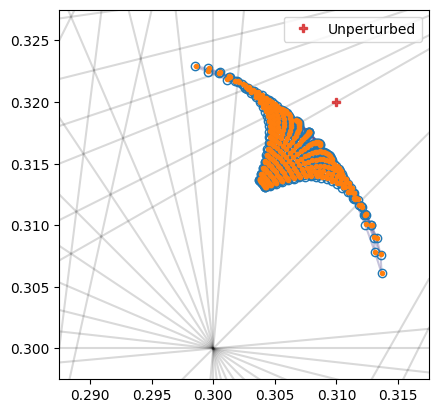

In [6]:
window    = 0.03
Qx_lim    = [Qx_0-3*window/4,Qx_0+window/4]
Qy_lim    = [Qy_0-3*window/4,Qy_0+window/4]


for tracked in [tracked_HO]:

    plt.close('all')
    plt.figure()
    bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)


    tracked._tunesMTD     = 'pynaff'
    tracked_ref._tunesMTD = 'pynaff'
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']

    Qx = Qx_0 + dQx
    Qy = Qy_0 + dQy
    bbplt.polarmesh(Qx,Qy,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
    plt.plot(Qx,Qy,'o',mfc='none')

    tracked._tunesMTD     = 'nafflib'
    tracked_ref._tunesMTD = 'nafflib'
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']

    Qx = Qx_0 + dQx
    Qy = Qy_0 + dQy
    plt.plot(Qx,Qy,'.')
    

    plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')
    plt.legend()
    plt.axis('square')
    plt.xlim(Qx_lim)
    plt.ylim(Qy_lim)
    plt.savefig(f'tmp_fig/footprint_HO.png',format='png')


for idx,tracked in enumerate(tracking_results[::-1]):

    plt.close('all')
    plt.figure()
    bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)


    tracked._tunesMTD     = 'pynaff'
    tracked_ref._tunesMTD = 'pynaff'
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']

    Qx = Qx_0 + dQx
    Qy = Qy_0 + dQy
    bbplt.polarmesh(Qx,Qy,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
    plt.plot(Qx,Qy,'o',mfc='none')

    tracked._tunesMTD     = 'nafflib'
    tracked_ref._tunesMTD = 'nafflib'
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']

    Qx = Qx_0 + dQx
    Qy = Qy_0 + dQy
    plt.plot(Qx,Qy,'.')
    

    plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')
    plt.legend()
    plt.axis('equal')
    plt.xlim([0.308,0.312])
    plt.ylim([0.318,0.322])
    plt.savefig(f'tmp_fig/footprint_lr_{str(idx).zfill(2)}.png',format='png')


plt.close('all')
plt.figure()
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)

tracked._tunesMTD     = 'pynaff'
tracked_ref._tunesMTD = 'pynaff'
Qx_tot = np.zeros(len(tracked.tunes_n['Qx']))+ Qx_0
Qy_tot = np.zeros(len(tracked.tunes_n['Qx']))+ Qy_0
for idx,tracked in enumerate(tracking_results + [tracked_HO]):
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']
    Qx_tot += dQx
    Qy_tot += dQy
bbplt.polarmesh(Qx_tot,Qy_tot,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
plt.plot(Qx_tot,Qy_tot,'o',mfc='none')

tracked._tunesMTD     = 'nafflib'
tracked_ref._tunesMTD = 'nafflib'
Qx_tot = np.zeros(len(tracked.tunes_n['Qx']))+ Qx_0
Qy_tot = np.zeros(len(tracked.tunes_n['Qx']))+ Qy_0
for idx,tracked in enumerate(tracking_results+[tracked_HO]):
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']
    Qx_tot += dQx
    Qy_tot += dQy
plt.plot(Qx_tot,Qy_tot,'.')
plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')

plt.legend(loc='upper right')
plt.axis('square')
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)
plt.savefig(f'tmp_fig/footprint_TOTAL.png',format='png')

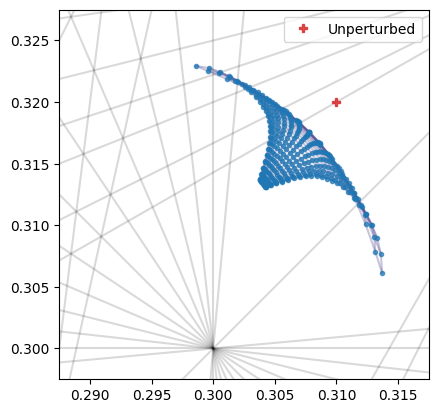

In [7]:
window    = 0.03
Qx_lim    = [Qx_0-3*window/4,Qx_0+window/4]
Qy_lim    = [Qy_0-3*window/4,Qy_0+window/4]


for tracked in [tracked_HO]:

    plt.close('all')
    plt.figure()
    bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)


    tracked._tunesMTD     = 'pynaff'
    tracked_ref._tunesMTD = 'pynaff'
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']

    Qx = Qx_0 + dQx
    Qy = Qy_0 + dQy
    bbplt.polarmesh(Qx,Qy,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
    plt.plot(Qx,Qy,'.',alpha=0.7)
    

    plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')
    plt.legend()
    plt.axis('square')
    plt.xlim(Qx_lim)
    plt.ylim(Qy_lim)
    plt.savefig(f'tmp_fig2/footprint_HO.png',format='png')


for idx,tracked in enumerate(tracking_results[::-1]):

    plt.close('all')
    plt.figure()
    bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)


    tracked._tunesMTD     = 'pynaff'
    tracked_ref._tunesMTD = 'pynaff'
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']

    Qx = Qx_0 + dQx
    Qy = Qy_0 + dQy
    bbplt.polarmesh(Qx,Qy,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
    plt.plot(Qx,Qy,'.',alpha=0.7)
    

    plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')
    plt.legend()
    plt.axis('equal')
    plt.xlim([0.308,0.312])
    plt.ylim([0.318,0.322])
    plt.savefig(f'tmp_fig2/footprint_lr_{str(idx).zfill(2)}.png',format='png')


plt.close('all')
plt.figure()
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)

tracked._tunesMTD     = 'pynaff'
tracked_ref._tunesMTD = 'pynaff'
Qx_tot = np.zeros(len(tracked.tunes_n['Qx']))+ Qx_0
Qy_tot = np.zeros(len(tracked.tunes_n['Qx']))+ Qy_0
for idx,tracked in enumerate(tracking_results + [tracked_HO]):
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']
    Qx_tot += dQx
    Qy_tot += dQy
bbplt.polarmesh(Qx_tot,Qy_tot,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
plt.plot(Qx_tot,Qy_tot,'.',alpha=0.7)

plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')

plt.legend(loc='upper right')
plt.axis('square')
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)
plt.savefig(f'tmp_fig2/footprint_TOTAL.png',format='png')

In [8]:
sys.exit(0)

SystemExit: 0

/home/phbelang/abp/BBStudies/Executables/py_BB/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3386: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


(0.295, 0.34500000000000003)

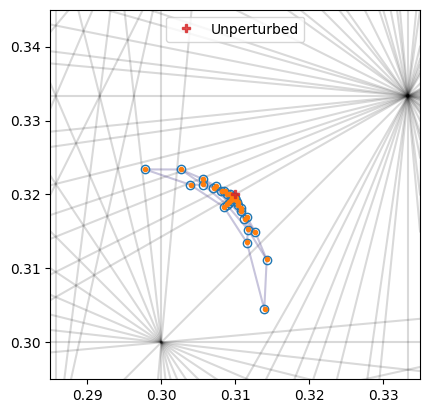

In [ ]:
plt.close('all')
plt.figure()
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)

tracked._tunesMTD     = 'pynaff'
tracked_ref._tunesMTD = 'pynaff'
Qx_tot = np.zeros(len(tracked.tunes_n['Qx']))+ Qx_0
Qy_tot = np.zeros(len(tracked.tunes_n['Qx']))+ Qy_0
for idx,tracked in enumerate(tracking_results):
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes['Qy']
    Qx_tot += dQx
    Qy_tot += dQy
bbplt.polarmesh(Qx_tot,Qy_tot,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
plt.plot(Qx_tot,Qy_tot,'o',mfc='none')

tracked._tunesMTD     = 'nafflib'
tracked_ref._tunesMTD = 'nafflib'
Qx_tot = np.zeros(len(tracked.tunes_n['Qx']))+ Qx_0
Qy_tot = np.zeros(len(tracked.tunes_n['Qx']))+ Qy_0
for idx,tracked in enumerate(tracking_results):
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes['Qy']
    Qx_tot += dQx
    Qy_tot += dQy
plt.plot(Qx_tot,Qy_tot,'.')
plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')

plt.legend()
plt.axis('square')
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)

In [ ]:
sys.exit(0)

SystemExit: 0

/home/phbelang/abp/BBStudies/Executables/py_BB/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3386: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
coordinates

,delta,r_sig,theta_sig,x_sig,y_sig,x_n,y_n,J_x,J_y
0,0,1.0,0.047124,0.998890,0.047106,0.000019,8.748435e-07,1.720700e-10,3.826756e-13
1,0,2.0,0.047124,1.997780,0.094213,0.000037,1.749687e-06,6.882801e-10,1.530702e-12
2,0,3.0,0.047124,2.996670,0.141319,0.000056,2.624530e-06,1.548630e-09,3.444080e-12
3,0,4.0,0.047124,3.995559,0.188426,0.000074,3.499374e-06,2.753120e-09,6.122809e-12
4,0,5.0,0.047124,4.994449,0.235532,0.000093,4.374217e-06,4.301750e-09,9.566889e-12
...,...,...,...,...,...,...,...,...,...
65,0,6.0,1.523672,0.282639,5.993339,0.000005,1.113061e-04,1.377632e-11,6.194520e-09
66,0,7.0,1.523672,0.329745,6.992229,0.000006,1.298571e-04,1.875110e-11,8.431431e-09
67,0,8.0,1.523672,0.376852,7.991119,0.000007,1.484081e-04,2.449124e-11,1.101248e-08
68,0,9.0,1.523672,0.423958,8.990009,0.000008,1.669591e-04,3.099672e-11,1.393767e-08


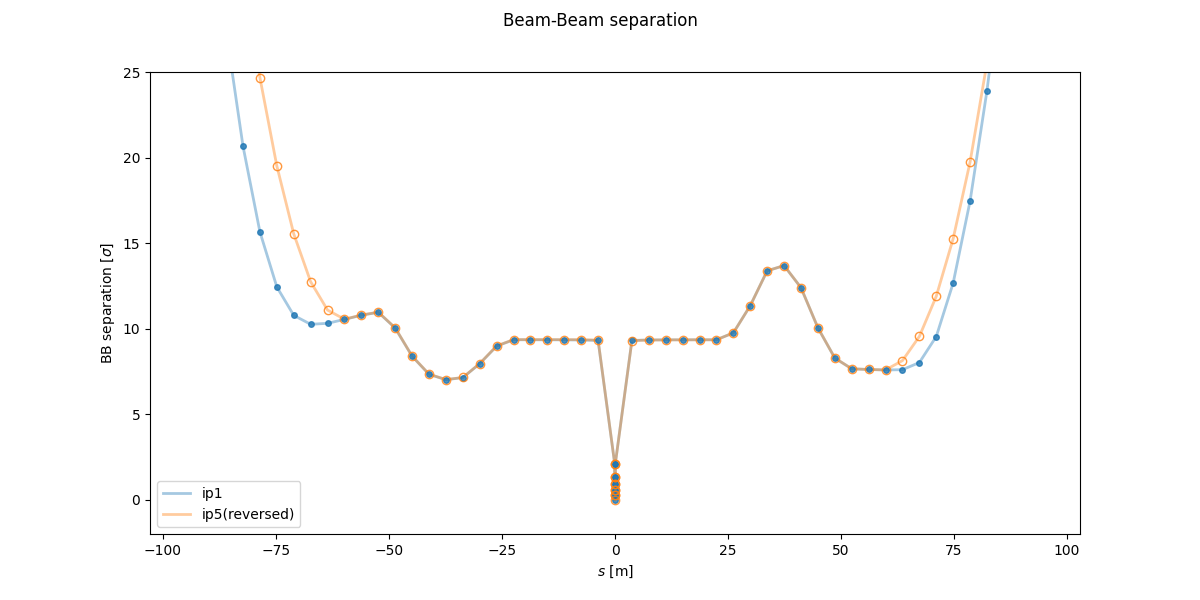

In [ ]:
fig = plt.figure(figsize=(12,6))
fig.suptitle(f'Beam-Beam separation')

for _IP in [IP1,IP5]:
    
    # Plotting   
   
    dx_n_tot = np.sqrt(_IP.bb['dx_n']**2 + _IP.bb['dy_n']**2)
    if _IP.name == 'ip1':
        plt.plot(_IP.bb['s'],dx_n_tot,'-',color='C0',alpha=0.4,lw=2,label=_IP.name,zorder=-10)
        plt.plot(_IP.bb['s'],dx_n_tot,ls='' ,color='C0',alpha=0.8,marker='.',ms=8)
    else:
        plt.plot(-_IP.bb['s'],dx_n_tot,'-',color='C1',alpha=0.4,lw=2,label=_IP.name + '(reversed)',zorder=-9)
        plt.plot(-_IP.bb['s'],dx_n_tot,ls='' ,color='C1',alpha=0.8,marker='.',mfc='none',ms=12)
    plt.legend()
    
    plt.xlabel(r'$s$ [m]')
    plt.ylabel(r'BB separation [$\sigma$]')
    
    plt.ylim([-2,25])

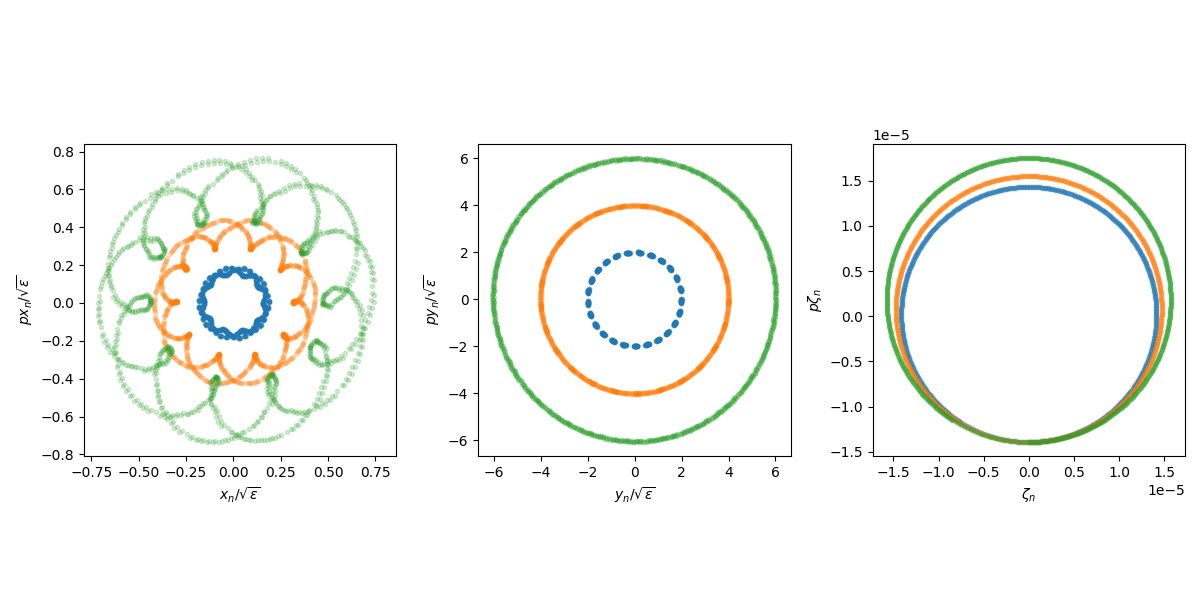

In [ ]:

%matplotlib widget
theta_vec = np.linspace(0,2*np.pi,200)
plt.figure(figsize=(12,6))
for _ID,_part in tracked.df.groupby('particle'):
    
    if coordinates.loc[_ID,'theta_sig']==np.linspace(0.05*np.pi/2,0.95*np.pi/2,5)[4]:
        #plt.plot(_part.turn,np.sqrt(2*Jx)/np.sqrt(B1.emittx),alpha=0.5)
        plt.subplot(1,3,1)
        plt.plot(_part.x_n/np.sqrt(B1.emittx),_part.px_n/np.sqrt(B1.emittx),'.',alpha=0.2)
        this_color = plt.gca().lines[-1].get_color()
        #plt.plot(coordinates.loc[_ID,'x_n']*np.cos(theta_vec)/np.sqrt(B1.emittx),coordinates.loc[_ID,'x_n']*np.sin(theta_vec)/np.sqrt(B1.emittx),alpha=0.8,color=plt.gca().lines[-1].get_color())
        plt.subplot(1,3,2)
        plt.plot(_part.y_n/np.sqrt(B1.emitty),_part.py_n/np.sqrt(B1.emitty),'.',color=this_color,alpha=0.2)
        #plt.plot(coordinates.loc[_ID,'y_n']*np.cos(theta_vec)/np.sqrt(B1.emitty),coordinates.loc[_ID,'y_n']*np.sin(theta_vec)/np.sqrt(B1.emitty),alpha=0.8,color=plt.gca().lines[-1].get_color())
        plt.subplot(1,3,3)
        plt.plot(_part.zeta_n,_part.pzeta_n,'.',color=this_color,alpha=0.2)
#plt.xlim([0,200])
plt.subplot(1,3,1)
plt.axis('square')
plt.xlabel(r'$x_n/\sqrt{\varepsilon}$')
plt.ylabel(r'$px_n/\sqrt{\varepsilon}$')
plt.subplot(1,3,2)
plt.axis('square')
plt.xlabel(r'$y_n/\sqrt{\varepsilon}$')
plt.ylabel(r'$py_n/\sqrt{\varepsilon}$')
plt.subplot(1,3,3)
plt.axis('square')
plt.xlabel(r'$\zeta_n$')
plt.ylabel(r'$p\zeta_n$')
#plt.ylim([-1e-4,1e-4])

plt.tight_layout()

(0.295, 0.34500000000000003)

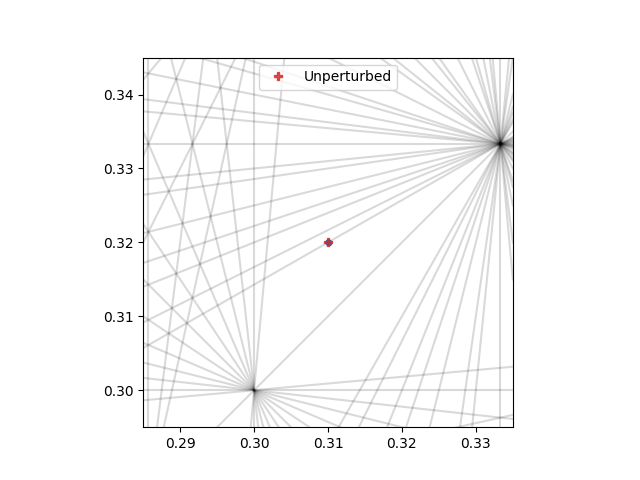

In [ ]:
plt.figure()
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)
plt.plot(tracked.tunes['Qx'],tracked.tunes['Qy'],'.')
plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')

plt.legend()
plt.axis('square')
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)


In [ ]:

tw_final = tracker.twiss()
print('\nFinal twiss parameters')
print(f"Qx = {tw_final['qx']:.5f} Qy = {tw_final['qy']:.5f} "
      f"Q'x = {tw_final['dqx']:.5f} Q'y = {tw_final['dqy']:.5f}")
#===================================


Final twiss parameters
Qx = 62.30966 Qy = 60.31979 Q'x = -193.13324 Q'y = -191.17286


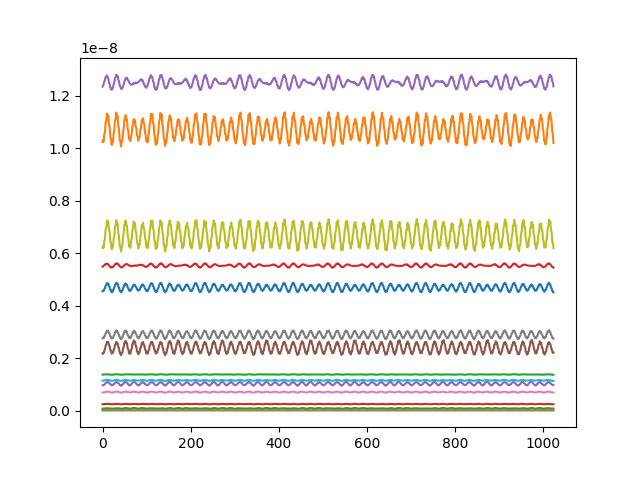

In [ ]:
plt.figure()
for _ID,_part in tracked.df.groupby('particle'):
    plt.plot(_part.turn,_part.y_n**2+_part.py_n**2)

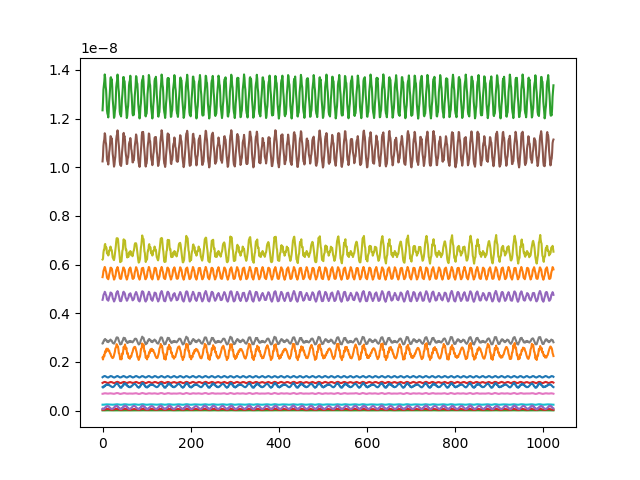

In [ ]:
plt.figure()
for _ID,_part in tracked.df.groupby('particle'):
    plt.plot(_part.turn,_part.x_n**2+_part.px_n**2)

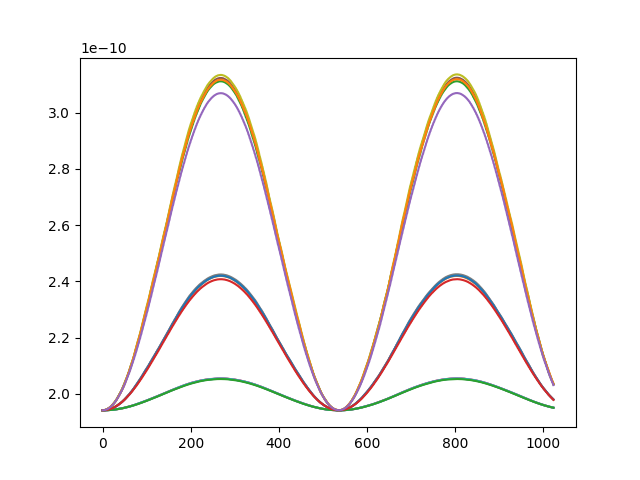

In [ ]:
plt.figure()
for _ID,_part in tracked.df.groupby('particle'):
    plt.plot(_part.turn,_part.pzeta_n**2+_part.zeta_n**2)

In [ ]:
tracked.particles.x == particles.x

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

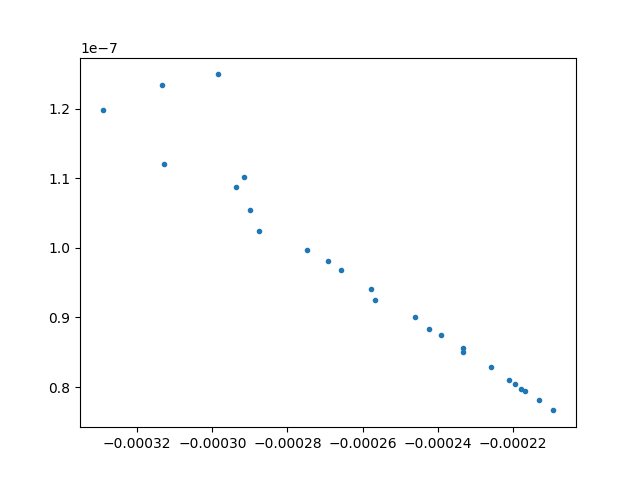

In [ ]:
plt.figure()
plt.plot(tracked.particles.to_pandas()['zeta'],tracked.particles.to_pandas()['delta'],'.')

(0.295, 0.34500000000000003)

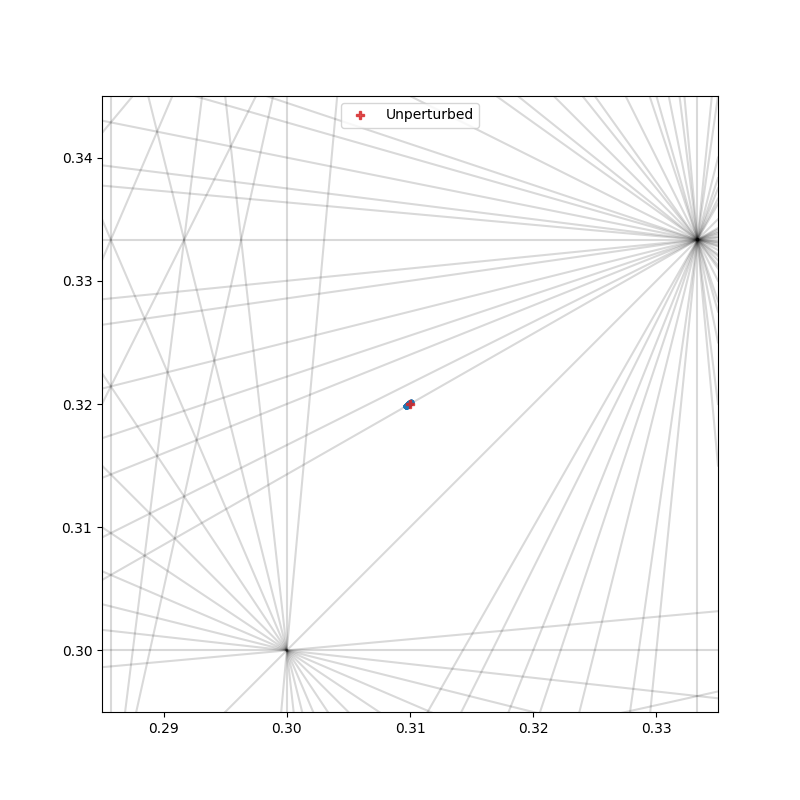

In [ ]:
%matplotlib widget

window    = 0.05
Qx_lim    = [Qx_0-window/2,Qx_0+window/2]
Qy_lim    = [Qy_0-window/2,Qy_0+window/2]

plt.figure(figsize=(8,8))
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)
tracked._tunesMTD = 'pynaff'
bbplt.polarmesh(tracked.tunes['Qx'],tracked.tunes['Qy'],r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
plt.plot(tracked.tunes['Qx'],tracked.tunes['Qy'],'.')
plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')


plt.legend()
plt.axis('square')
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)